### Setting up dependencies and keys

In [4]:
# Dependencies
import json
import tweepy
import apikeys
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Twitter API Keys
consumer_key = apikeys.TWITTER_CONSUMER_KEY
consumer_secret = apikeys.TWITTER_CONSUMER_SECRET
access_token = apikeys.TWITTER_ACCESS_TOKEN
access_token_secret = apikeys.TWITTER_ACCESS_TOKEN_SECRET

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())


### Calling Twitter API for tweets by outlets
Setup the target users (news outlet handles) into a list.  Then declared a dictionary to store each of the 100 sentiments into respective news outlet names.  Procede looping through the target users: set the key (target user name) AND set another list to hold all of the tweet sentiment values.  Set up another loop to loop through each page of 20 tweets, total of 5 pages.  Within each page, pull each tweet info, then pull each tweet['text'], analyze via VADER, then append that data to the list holding all of the tweet sentiment values (tweet_text_values).  After all the values from the pages have been analyzed, then the list is stored into the dictionary under the appropriate key holding the outlet agency.  List of values is then cleared again, to be used on the next agency.

In [5]:
target_users = ['nytimes', 'BBCWorld', 'CBSNews', 'CNN', 'FoxNews']

outlet_tweet_dict = {}

for each in target_users:
    outlet_tweet_dict[each] = ""
    tweet_text_values = []
    for page_num in range(5):
    
        public_tweets = api.user_timeline(each, page=page_num)
        #print(json.dumps(public_tweets, sort_keys=True, indent=4))

        for tweet in public_tweets:
            scores = analyzer.polarity_scores(tweet['text'])
            #print(tweet["text"])
            tweet_text_values.append(scores['compound'])
            
    outlet_tweet_dict[each] = tweet_text_values
    #print(len(tweet_texts))
    #print(len(outlet_tweet_dict))
print("Successful")

1
2
3
4
5


In [6]:
# We have a dictionary of lists, so we can now set up a dataframe

outlet_tweet_dict_df = pd.DataFrame(outlet_tweet_dict)
outlet_tweet_dict_df.head()

,BBCWorld,CBSNews,CNN,FoxNews,nytimes
0,0.3400,-0.1779,0.0,0.7506,0.5423
1,0.5423,0.0000,0.0,-0.7351,0.8481
2,0.0000,0.7783,0.0,0.0258,0.0000
3,0.0000,0.6369,0.0,0.7096,0.2235
4,0.0000,0.8360,0.0,0.0000,0.0000


In [7]:
# The dataframe created, STARTS AT THE LATEST TWEET, hence when plotted, it will go from recent to past (in index order).
# We need the data to go from past to recent, hence the dataframe MUST be inverted indexing.  So the invert happens after the
# iloc, then the dataframe is reset with a new index to be iterated, and an old index for the labels.

outlet_rev_df = outlet_tweet_dict_df.iloc[::-1].reset_index()
outlet_rev_df.head()

,index,BBCWorld,CBSNews,CNN,FoxNews,nytimes
0,99,-0.6597,-0.5106,0.4019,-0.6705,-0.5574
1,98,0.0000,0.1779,0.0000,0.3400,0.8020
2,97,0.3182,0.0000,0.3818,0.4215,0.0000
3,96,0.0000,-0.1531,0.4767,0.2263,0.0000
4,95,-0.0772,0.0000,-0.5994,0.0000,0.0000


In [319]:
# plt.scatter(outlet_rev['index'], outlet_rev['BBCWorld'], marker="o", 
#             facecolors="red", edgecolors="black", alpha=0.95, s=30)

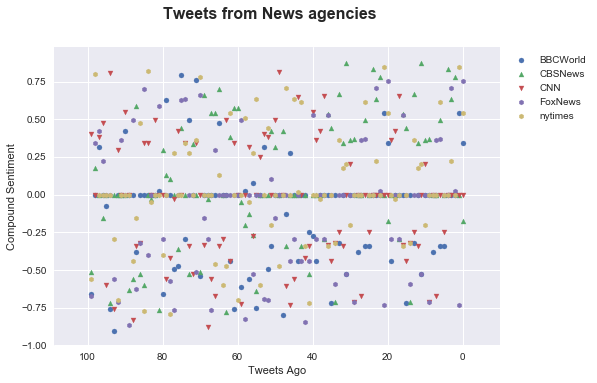

In [8]:
# Setting up the scatter plot using the SAME table.  Using subplots, the chart is defined and stored into a variable 'ax1'
# then the chart ax1 is plotted in reference to each news outlet.

fig, ax1 = plt.subplots(1, sharex=True, sharey= True)
fig.suptitle("Tweets from News agencies", fontsize=16,
             fontweight="bold")

ax1.set_xlim(max(outlet_rev_df['index'])+10, min(outlet_rev_df['index'])-10, 10)
ax1.scatter(outlet_rev_df['index'], outlet_rev_df['BBCWorld'], marker="o", s=25)
ax1.scatter(outlet_rev_df['index'], outlet_rev_df['CBSNews'], marker='^', s=25)
ax1.scatter(outlet_rev_df['index'], outlet_rev_df['CNN'], marker="v", s=25)
ax1.scatter(outlet_rev_df['index'], outlet_rev_df['FoxNews'], marker='h', s=25)
ax1.scatter(outlet_rev_df['index'], outlet_rev_df['nytimes'], marker='h', s=25)
ax1.set_ylabel("Compound Sentiment")
ax1.set_xlabel("Tweets Ago")
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', ncol=1)
#plt.legend()
#plt.xticks(range(len(outlet_rev['index'])), outlet_rev['index'])
plt.show()


### Creating bar chart
A dictionary is creating to store the keys (agency names) and the sum of the sentiments (value).  Later this is used to create a dataframe and ultimately bar graphed.

In [11]:
outlet_compound_total = {}

for outlet in outlet_tweet_dict:
    #Appending list (sum) to dictionary key, so the dictionary key will have an associated list
    outlet_compound_total[outlet] = [sum(outlet_tweet_dict[outlet])]
#print(outlet_compound_total)
#print(outlet_compound_total_list)

In [12]:
outlet_compound_df = pd.DataFrame(outlet_compound_total)
outlet_compound_df

,BBCWorld,CBSNews,CNN,FoxNews,nytimes
0,-10.8523,8.312,-5.359,-7.2285,4.008


In [13]:
# Need to transpose the data (turning columns to rows), otherwise, numpy will lump all of the news agencies into the
# one label (the 0 index, as the one label).  Index is then reset, so a dataseries can be created using
# outlet_compound_df['Outlets']

outlet_compound_trans = outlet_compound_df.transpose().rename(columns={0:"Compound Sentiment Total"}).reset_index().rename(columns={"index":"Outlets"})
outlet_compound_trans

,Outlets,Compound Sentiment Total
0,BBCWorld,-10.8523
1,CBSNews,8.3120
2,CNN,-5.3590
3,FoxNews,-7.2285
4,nytimes,4.0080


In [324]:
# outlet_bar_chart = outlet_compound_trans.plot(kind="bar", color=["b","g",'r'])
# outlet_bar_chart.set_title("Outlet Compound Sentiment Totals")
# outlet_bar_chart.set_xlabel("News Outlets")
# outlet_bar_chart.set_ylabel("Compound Sentiment Totals")
# plt.show()

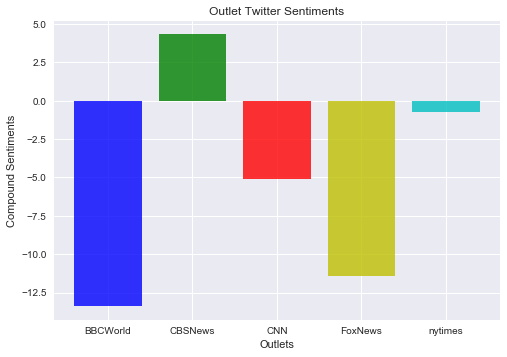

In [325]:

x_values = np.arange(len(target_users))
y_values = outlet_compound_trans['Compound Sentiment Total']
plt.bar(x_values, y_values, color='b''g''r''y''c', alpha=.8, tick_label=outlet_compound_trans['Outlets'])
plt.title("Outlet Twitter Sentiments")
plt.xlabel("Outlets")
plt.ylabel("Compound Sentiments")
plt.show()